In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from datetime import datetime

import findspark
import pyspark

from matplotlib import pyplot as plt

# 2. Grouping customers together!

### 2.1.1 Get the data + Feature engineering

In [5]:
data = pd.read_csv('bank_transactions.csv')

Some basic data cleaning.

In [7]:
data = data.dropna()
data.CustomerDOB = pd.to_datetime(data.CustomerDOB)

In [8]:
def convert_time(value):
    sec = value % 100
    minutes = (value//100)%100
    hours = (value//10000)%100
    date = str(hours)+":"+str(minutes)+":"+str(sec)
    datetime_object = datetime.strptime(date,'%H:%M:%S').time()
    return datetime_object

In [9]:
data.TransactionTime = data.TransactionTime.apply(lambda x: convert_time(int(x)))

In [10]:
data.TransactionDate = pd.to_datetime(data.TransactionDate)

In [11]:
data.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,14:32:07,25.0
1,T2,C2142763,2057-04-04,M,JHAJJAR,2270.69,2016-02-08,14:18:58,27999.0
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,14:27:12,459.0
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,14:27:14,2060.0
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,18:11:56,1762.5


In [12]:
data.drop(data[data.CustomerDOB.dt.year == 1800].index, axis=0, inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 985322 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   TransactionID            985322 non-null  object        
 1   CustomerID               985322 non-null  object        
 2   CustomerDOB              985322 non-null  datetime64[ns]
 3   CustGender               985322 non-null  object        
 4   CustLocation             985322 non-null  object        
 5   CustAccountBalance       985322 non-null  float64       
 6   TransactionDate          985322 non-null  datetime64[ns]
 7   TransactionTime          985322 non-null  object        
 8   TransactionAmount (INR)  985322 non-null  float64       
dtypes: datetime64[ns](2), float64(2), object(5)
memory usage: 75.2+ MB


In [13]:
data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)

To convert indian rupies in usd

In [14]:
data['CustAccountBalance'] = data['CustAccountBalance'].apply(lambda x: x*0.012)
data['TransactionAmount (INR)'] = data['TransactionAmount (INR)'].apply(lambda x: x*0.012)

In [70]:
data.to_csv('cleaned_data.csv',index=False)

In [155]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 985322 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   TransactionID            985322 non-null  object        
 1   CustomerID               985322 non-null  object        
 2   CustomerDOB              985322 non-null  datetime64[ns]
 3   CustGender               985322 non-null  object        
 4   CustLocation             985322 non-null  object        
 5   CustAccountBalance       985322 non-null  float64       
 6   TransactionDate          985322 non-null  datetime64[ns]
 7   TransactionTime          985322 non-null  object        
 8   TransactionAmount (INR)  985322 non-null  float64       
dtypes: datetime64[ns](2), float64(2), object(5)
memory usage: 75.2+ MB


Now we need to build a customer-view of the data. 

##### a) Number of transactions

In [15]:
num_transactions = data\
                   .groupby('CustomerID',as_index=False)\
                   .count()[['CustomerID','TransactionID']]\
                   .rename(columns={'TransactionID':'Number of transactions'})

##### b) Number of transactions with a balance bigger than 100 USD

In [16]:
high_transactions = data[data['CustAccountBalance'] > 100]\
                    .groupby('CustomerID', as_index=False)\
                    .count()[['CustomerID','TransactionID']]\
                    .rename(columns={'TransactionID':'Number of high volume transactions'})

##### c) Average amount of the transactions

In [17]:
average_transactions = data\
                       .groupby('CustomerID', as_index=False)\
                       .mean()[['CustomerID','TransactionAmount (INR)']]\
                       .rename(columns={'TransactionAmount (INR)':'AVG Transaction'})

##### d) Average balance

In [18]:
average_balance = data\
                  .groupby('CustomerID', as_index = False)\
                  .mean()[['CustomerID','CustAccountBalance']]\
                  .rename(columns={'CustAccountBalance':'AVG Balance'})

##### e) Average difference between the balance and the transaction amount for each customer 

In [19]:
data['Utilization'] = data['CustAccountBalance'] - data['TransactionAmount (INR)']

In [20]:
average_utilization = data\
                      .groupby('CustomerID', as_index = False)\
                      .mean()[['CustomerID','Utilization']]\
                      .rename(columns={'Utilization':'AVG Utilization'})

##### f) Most common gender of the customer

In [22]:
most_common_gender = data\
                     .groupby('CustomerID', as_index=False)['CustGender']\
                     .apply(lambda x: x.mode().iat[0])\
                     .rename(columns={'CustGender':'Most common gender'})

##### h) Most frequent location of the customer



In [23]:
most_common_location = data\
                       .groupby('CustomerID', as_index=False)['CustLocation']\
                       .apply(lambda x: x.mode().iat[0])\
                       .rename(columns={'CustLocation':'Most frequent location'})

Now we can concatenate our datasets to build a customer view of our transaction-data. 

In [24]:
customer_view = num_transactions\
                .merge(high_transactions, how='left')\
                .merge(average_transactions)\
                .merge(average_balance)\
                .merge(average_utilization)\
                .merge(most_common_gender)\
                .merge(most_common_location)

In [25]:
customer_view.fillna(0,inplace=True)

In [26]:
customer_view.to_csv('customer_view.csv', index=False)

In [82]:
customer_view = pd.read_csv('customer_view.csv')

In [27]:
customer_view

,CustomerID,Number of transactions,Number of high volume transactions,AVG Transaction,AVG Balance,AVG Utilization,Most common gender,Most frequent location
0,C1010011,2,2.0,30.636,916.08762,885.45162,F,NEW DELHI
1,C1010012,1,1.0,17.988,290.45388,272.46588,M,MUMBAI
2,C1010014,2,2.0,8.730,1201.35540,1192.62540,F,MUMBAI
3,C1010018,1,0.0,0.360,5.95416,5.59416,F,CHAMPARAN
4,C1010024,1,1.0,60.000,1044.70380,984.70380,M,KOLKATA
...,...,...,...,...,...,...,...,...
839076,C9099836,1,1.0,8.292,1596.80676,1588.51476,M,BHIWANDI
839077,C9099877,1,1.0,2.664,1152.76152,1150.09752,M,BANGALORE
839078,C9099919,1,0.0,1.512,66.71700,65.20500,M,GUNTUR
839079,C9099941,1,1.0,0.600,423.55104,422.95104,M,CHENNAI


#### ***Feature engineering: 20 new features***

The feature we defined are the following ones:
1) Customer age, leveraging one of the recorded dates of birthday
2) The transaction with the highest volume
3) The transaction with the lowest volume
4) The number of transactions recorded in New Delhi, 
5) The number of transactions recorded in Mumbai 
6) The number of transactions recorded in Bangalore
7) The day of the week in which each costumer made the most of his transactions
8) The month in which each costumer made the most of his transactions
9) The highest recorded value of his balance
10) The lowest recorded value of his balance
11) The number of transactions made when the balance was higher than its average
12) The highest recorded utilization
13) The lowest recorded utilization
14) The date of the last recorded transaction
15) The date of the first recorded transaction
16) The mean time between two transactions
17) The ration between the last recorded value for balance and the first recorded value for balance
18) The number of transactions higher than 1000 USD
19) The hour of the day when the customer made the most of his transactions
20) For each customer, the percentage of transactions made by female over the whole volume of transactions

Customer Age

In [28]:
data['CustomerAge'] = (( pd.to_datetime('today') - data.CustomerDOB ) / np.timedelta64(1, 'Y')).round(0)
data['CustomerAge'] = data['CustomerAge'].astype(int)

customer_view = customer_view.merge(data[['CustomerID','CustomerAge']], how='left')

customer_view = customer_view.drop_duplicates(subset=['CustomerID'])

Max transactions ever done

In [29]:
max_transactions = data[['CustomerID','TransactionAmount (INR)']]\
                    .groupby('CustomerID', as_index=False)\
                    .max()\
                    .rename(columns={'TransactionAmount (INR)':'MAX Transaction'})
                    
customer_view = customer_view.merge(max_transactions)

Min transaction


In [30]:
min_transactions = data[['CustomerID','TransactionAmount (INR)']]\
                    .groupby('CustomerID', as_index=False)\
                    .min()\
                    .rename(columns={'TransactionAmount (INR)':'MIN Transaction'})
                    
customer_view = customer_view.merge(min_transactions)

Number of visits in New Delhi 

In [31]:
visits_new_delhi = data[data.CustLocation == 'NEW DELHI'][['CustomerID','CustLocation']]\
                   .groupby('CustomerID', as_index=False)\
                   .count()\
                   .rename(columns={'CustLocation':'Number of visits in New Delhi'})
                   
customer_view = customer_view.merge(visits_new_delhi, how='left')


Number of visits in Mumbai

In [32]:
visits_mumbai = data[data.CustLocation == 'MUMBAI'][['CustomerID','CustLocation']]\
                .groupby('CustomerID', as_index=False)\
                .count()\
                .rename(columns={'CustLocation':'Number of visits in Mumbai'})
                
customer_view = customer_view.merge(visits_mumbai, how='left')

Number of visits in Bangalore. 

In [33]:
visits_bangalore = data[data.CustLocation == 'BANGALORE'][['CustomerID','CustLocation']]\
                    .groupby('CustomerID', as_index=False)\
                    .count()\
                    .rename(columns={'CustLocation':'Number of visits in Bangalore'})

customer_view = customer_view.merge(visits_bangalore, how='left')

Day of the week in which he does the most of transactions. 

In [34]:
data['Day of the week'] = data.TransactionDate.dt.dayofweek

favourite_day = data\
                .groupby('CustomerID', as_index = False)['Day of the week']\
                .apply(lambda x: x.mode().iat[0])\
                .rename(columns={'Day of the week':'Favourite day of the week'})
                
customer_view = customer_view.merge(favourite_day)

Max balance

In [35]:
max_balance = data[['CustomerID','CustAccountBalance']]\
                .groupby('CustomerID', as_index = False)\
                    .max()\
                        .rename(columns={'CustAccountBalance':'Max Balance'})
                        
customer_view = customer_view.merge(max_balance)

Min balance

In [36]:
min_balance = data[['CustomerID','CustAccountBalance']]\
                .groupby('CustomerID', as_index = False)\
                    .min()\
                        .rename(columns={'CustAccountBalance':'Min Balance'})
                        
customer_view = customer_view.merge(min_balance)

Month with the most recorded transactions

In [37]:
data['Month'] = data.TransactionDate.dt.month

favourite_month = data\
                .groupby('CustomerID', as_index = False)['Month']\
                .apply(lambda x: x.mode().iat[0])\
                .rename(columns={'Month':'Favourite Month'})
                
customer_view = customer_view.merge(favourite_month)

Number of transactions when balance was over the mean balance.

In [38]:
data = data.merge(customer_view[['CustomerID','AVG Balance']], how='left')

useful_view = data[data.CustAccountBalance > data['AVG Balance']]

filtered_mean_balance_transactions = useful_view[['CustomerID','TransactionID']]\
                                        .groupby('CustomerID', as_index=0)\
                                            .count()\
                                                .rename(columns={'TransactionID':'Transaction when balance higher than the AVG'})
                                                
customer_view = customer_view.merge(filtered_mean_balance_transactions, how ='left')

Max utilization

In [39]:
max_utilization = data[['CustomerID','Utilization']]\
                .groupby('CustomerID', as_index = False)\
                    .max()\
                        .rename(columns={'Utilization':'Max Utilization'})
                        
customer_view = customer_view.merge(max_utilization)

Min utilization

In [40]:
min_utilization = data[['CustomerID','Utilization']]\
                .groupby('CustomerID', as_index = False)\
                    .min()\
                        .rename(columns={'Utilization':'Min Utilization'})
                        
customer_view = customer_view.merge(min_utilization)

Last transaction

In [41]:
last_transactions = data[['CustomerID','TransactionDate']]\
                                    .groupby('CustomerID', as_index=False)\
                                        .max()\
                                            .rename(columns={'TransactionDate':'Last transaction'})
                                            
customer_view = customer_view.merge(last_transactions)

First transaction

In [42]:
first_transactions = data[['CustomerID','TransactionDate']]\
                                    .groupby('CustomerID', as_index=False)\
                                        .min()\
                                            .rename(columns={'TransactionDate':'First transaction'})
                                            
customer_view = customer_view.merge(first_transactions)

Mean time between transactions

In [43]:
mean_time_between_transactions = (customer_view['Last transaction']-customer_view['First transaction'])/(customer_view['Number of transactions']-1)

customer_view['Mean time between transactions'] = mean_time_between_transactions

Ratio between final recorded balance and first recorded balance

In [44]:
first_recorded_balance = data[['CustomerID','CustAccountBalance','TransactionDate']].sort_values(by='TransactionDate')\
                         .groupby('CustomerID', as_index=False)\
                         .min()\
                         .rename(columns={'CustAccountBalance':'First balance'})

last_recorded_balance = data[['CustomerID','CustAccountBalance','TransactionDate']].sort_values(by='TransactionDate')\
                         .groupby('CustomerID', as_index=False)\
                         .max()\
                         .rename(columns={'CustAccountBalance':'Last balance'})

customer_view['Balance traction'] = (last_recorded_balance['Last balance'] - first_recorded_balance['First balance'])/first_recorded_balance['First balance']

Number of transactions higher than 1000 USD. 

In [45]:
highest_transactions = data[data['CustAccountBalance'] > 1000]\
                       .groupby('CustomerID', as_index=False)\
                       .count()[['CustomerID','TransactionID']]\
                       .rename(columns={'TransactionID':'Number of higher volume transactions'})
                       
customer_view = customer_view.merge(highest_transactions, how='left')

Favourite hour

In [47]:
hour = []
for idx in list(data.index.values):
    hour.append(data.TransactionTime[idx].hour)

data['Hour'] = hour

favourite_hour = data\
                 .groupby('CustomerID',as_index=False)['Hour']\
                 .apply(lambda x: x.mode().iat[0])\
                 .rename(columns={'Hour':'Favourite Hour'})
                 
customer_view = customer_view.merge(favourite_hour)

Percentage of female outgo

In [46]:
female_outgo = data[data['CustGender'] == 'F'][['CustomerID','TransactionAmount (INR)']]\
                             .groupby('CustomerID', as_index=False)\
                             .sum()\
                             .rename(columns={'TransactionAmount (INR)':'Female outgo'})

total_transactions = data[['CustomerID','TransactionAmount (INR)']]\
                     .groupby('CustomerID', as_index=False)\
                     .sum()\
                     .rename(columns={'TransactionAmount (INR)':'Total transaction'})
            
customer_view['Female outgo'] = female_outgo['Female outgo']/total_transactions['Total transaction']

In [48]:
customer_view

,CustomerID,Number of transactions,Number of high volume transactions,AVG Transaction,AVG Balance,AVG Utilization,Most common gender,Most frequent location,CustomerAge,MAX Transaction,...,Transaction when balance higher than the AVG,Max Utilization,Min Utilization,Last transaction,First transaction,Mean time between transactions,Balance traction,Number of higher volume transactions,Female outgo,Favourite Hour
0,C1010011,2,2.0,30.636,916.08762,885.45162,F,NEW DELHI,30,57.000,...,1.0,1437.89448,333.00876,2016-09-26,2016-09-08,18 days,2.697780,1.0,0.930278,1
1,C1010012,1,1.0,17.988,290.45388,272.46588,M,MUMBAI,28,17.988,...,NaN,272.46588,272.46588,2016-08-14,2016-08-14,NaT,0.000000,NaN,0.803869,20
2,C1010014,2,2.0,8.730,1201.35540,1192.62540,F,MUMBAI,31,14.460,...,1.0,1939.18512,446.06568,2016-07-08,2016-01-08,182 days,3.217322,1.0,0.020619,15
3,C1010018,1,0.0,0.360,5.95416,5.59416,F,CHAMPARAN,33,0.360,...,NaN,5.59416,5.59416,2016-09-15,2016-09-15,NaT,0.000000,NaN,18.566667,17
4,C1010024,1,1.0,60.000,1044.70380,984.70380,M,KOLKATA,57,60.000,...,NaN,984.70380,984.70380,2016-08-18,2016-08-18,NaT,0.000000,1.0,0.020000,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839076,C9099836,1,1.0,8.292,1596.80676,1588.51476,M,BHIWANDI,32,8.292,...,NaN,1588.51476,1588.51476,2016-07-08,2016-07-08,NaT,0.000000,1.0,NaN,0
839077,C9099877,1,1.0,2.664,1152.76152,1150.09752,M,BANGALORE,26,2.664,...,NaN,1150.09752,1150.09752,2016-09-15,2016-09-15,NaT,0.000000,1.0,NaN,12
839078,C9099919,1,0.0,1.512,66.71700,65.20500,M,GUNTUR,29,1.512,...,NaN,65.20500,65.20500,2016-08-18,2016-08-18,NaT,0.000000,NaN,NaN,12
839079,C9099941,1,1.0,0.600,423.55104,422.95104,M,CHENNAI,28,0.600,...,NaN,422.95104,422.95104,2016-08-28,2016-08-28,NaT,0.000000,NaN,NaN,21


In [49]:
customer_view.to_csv('customer_engineered.csv')

*Some quick data cleaning...*

In [2]:
customer_view = pd.read_csv('customer_engineered.csv')

In [4]:
customer_view['Mean time between transactions'].fillna(pd.Timedelta('0 days'), inplace=True)

In [5]:
customer_view.fillna(0,inplace=True)


In [6]:
customer_view.isna().sum()

Unnamed: 0                                      0
CustomerID                                      0
Number of transactions                          0
Number of high volume transactions              0
AVG Transaction                                 0
AVG Balance                                     0
AVG Utilization                                 0
Most common gender                              0
Most frequent location                          0
CustomerAge                                     0
MAX Transaction                                 0
MIN Transaction                                 0
Number of visits in New Delhi                   0
Number of visits in Mumbai                      0
Number of visits in Bangalore                   0
Favourite day of the week                       0
Max Balance                                     0
Min Balance                                     0
Favourite Month                                 0
Transaction when balance higher than the AVG    0


In [7]:
customer_view.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839081 entries, 0 to 839080
Data columns (total 29 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   Unnamed: 0                                    839081 non-null  int64  
 1   CustomerID                                    839081 non-null  object 
 2   Number of transactions                        839081 non-null  int64  
 3   Number of high volume transactions            839081 non-null  float64
 4   AVG Transaction                               839081 non-null  float64
 5   AVG Balance                                   839081 non-null  float64
 6   AVG Utilization                               839081 non-null  float64
 7   Most common gender                            839081 non-null  object 
 8   Most frequent location                        839081 non-null  object 
 9   CustomerAge                                   83

In [8]:
customer_view.head()

,Unnamed: 0,CustomerID,Number of transactions,Number of high volume transactions,AVG Transaction,AVG Balance,AVG Utilization,Most common gender,Most frequent location,CustomerAge,...,Transaction when balance higher than the AVG,Max Utilization,Min Utilization,Last transaction,First transaction,Mean time between transactions,Balance traction,Number of higher volume transactions,Female outgo,Favourite Hour
0,0,C1010011,2,2.0,30.636,916.08762,885.45162,F,NEW DELHI,30,...,1.0,1437.89448,333.00876,2016-09-26,2016-09-08,18 days 00:00:00,2.697780,1.0,0.930278,1
1,1,C1010012,1,1.0,17.988,290.45388,272.46588,M,MUMBAI,28,...,0.0,272.46588,272.46588,2016-08-14,2016-08-14,0 days 00:00:00,0.000000,0.0,0.803869,20
2,2,C1010014,2,2.0,8.730,1201.35540,1192.62540,F,MUMBAI,31,...,1.0,1939.18512,446.06568,2016-07-08,2016-01-08,182 days 00:00:00,3.217322,1.0,0.020619,15
3,3,C1010018,1,0.0,0.360,5.95416,5.59416,F,CHAMPARAN,33,...,0.0,5.59416,5.59416,2016-09-15,2016-09-15,0 days 00:00:00,0.000000,0.0,18.566667,17
4,4,C1010024,1,1.0,60.000,1044.70380,984.70380,M,KOLKATA,57,...,0.0,984.70380,984.70380,2016-08-18,2016-08-18,0 days 00:00:00,0.000000,1.0,0.020000,14


### ***Time for PCA***

In order to apply principal component analysis we have to consider only the numeric features, so we are dropping some columns from the dataset. 

In [3]:
customer_view = pd.read_csv('customer_engineered.csv')

In [9]:
customer_view

,Unnamed: 0,CustomerID,Number of transactions,Number of high volume transactions,AVG Transaction,AVG Balance,AVG Utilization,Most common gender,Most frequent location,CustomerAge,...,Transaction when balance higher than the AVG,Max Utilization,Min Utilization,Last transaction,First transaction,Mean time between transactions,Balance traction,Number of higher volume transactions,Female outgo,Favourite Hour
0,0,C1010011,2,2.0,30.636,916.08762,885.45162,F,NEW DELHI,30,...,1.0,1437.89448,333.00876,2016-09-26,2016-09-08,18 days 00:00:00,2.697780,1.0,0.930278,1
1,1,C1010012,1,1.0,17.988,290.45388,272.46588,M,MUMBAI,28,...,0.0,272.46588,272.46588,2016-08-14,2016-08-14,0 days 00:00:00,0.000000,0.0,0.803869,20
2,2,C1010014,2,2.0,8.730,1201.35540,1192.62540,F,MUMBAI,31,...,1.0,1939.18512,446.06568,2016-07-08,2016-01-08,182 days 00:00:00,3.217322,1.0,0.020619,15
3,3,C1010018,1,0.0,0.360,5.95416,5.59416,F,CHAMPARAN,33,...,0.0,5.59416,5.59416,2016-09-15,2016-09-15,0 days 00:00:00,0.000000,0.0,18.566667,17
4,4,C1010024,1,1.0,60.000,1044.70380,984.70380,M,KOLKATA,57,...,0.0,984.70380,984.70380,2016-08-18,2016-08-18,0 days 00:00:00,0.000000,1.0,0.020000,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839076,839076,C9099836,1,1.0,8.292,1596.80676,1588.51476,M,BHIWANDI,32,...,0.0,1588.51476,1588.51476,2016-07-08,2016-07-08,0 days 00:00:00,0.000000,1.0,0.000000,0
839077,839077,C9099877,1,1.0,2.664,1152.76152,1150.09752,M,BANGALORE,26,...,0.0,1150.09752,1150.09752,2016-09-15,2016-09-15,0 days 00:00:00,0.000000,1.0,0.000000,12
839078,839078,C9099919,1,0.0,1.512,66.71700,65.20500,M,GUNTUR,29,...,0.0,65.20500,65.20500,2016-08-18,2016-08-18,0 days 00:00:00,0.000000,0.0,0.000000,12
839079,839079,C9099941,1,1.0,0.600,423.55104,422.95104,M,CHENNAI,28,...,0.0,422.95104,422.95104,2016-08-28,2016-08-28,0 days 00:00:00,0.000000,0.0,0.000000,21


In [28]:
new_customer_view['Mean time between transactions'].fillna('0 days 00:00:00', inplace=True)

In [10]:
new_customer_view = customer_view.drop(columns=['Most common gender', 'Most frequent location', 'Last transaction', 'First transaction'])

In [17]:
new_customer_view['Mean time between transactions'] = new_customer_view['Mean time between transactions'].apply(lambda x: int(str(x)[:-14]))

In [18]:
new_customer_view.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839081 entries, 0 to 839080
Data columns (total 25 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   Unnamed: 0                                    839081 non-null  int64  
 1   CustomerID                                    839081 non-null  object 
 2   Number of transactions                        839081 non-null  int64  
 3   Number of high volume transactions            839081 non-null  float64
 4   AVG Transaction                               839081 non-null  float64
 5   AVG Balance                                   839081 non-null  float64
 6   AVG Utilization                               839081 non-null  float64
 7   CustomerAge                                   839081 non-null  int64  
 8   MAX Transaction                               839081 non-null  float64
 9   MIN Transaction                               83

In [19]:
new_customer_view.isna().sum()
new_customer_view.replace([np.inf, -np.inf], 0, inplace=True)

Now we want to set the CustomerID as the index set for our dataframe.

In [20]:
new_customer_view = new_customer_view.set_index('CustomerID')
new_customer_view = new_customer_view.drop(columns=['Unnamed: 0'])

Now we have only numerical features, so we can apply PCA. In order to do this, we define our PCA class:

In [139]:
class PCA:
    def __init__(self, dimension):
        self.dimension = dimension

    def standardize(self, data):
        data = data.copy()
        for column in data.columns:
            data[column] = (data[column]-data[column].mean())/data[column].std()
        return data.to_numpy()
            
    def decomposition(self,data):
        stand = self.standardize(data)
        cov_matrix = np.cov(stand, rowvar=False)
        self.eig_vals, self.eig_vecs = np.linalg.eigh(cov_matrix)
        
        self.eigen = [(self.eig_vals[i], self.eig_vecs[i,:]) for i in range(len(self.eig_vals))]
        self.eigen.sort(key = lambda tup: tup[0], reverse=True)

        self.eig_vals_sorted = np.array([pair[0] for pair in self.eigen])
        self.eig_vecs_sorted = np.array([pair[1] for pair in self.eigen])
        
        self.proj_matrix = self.eig_vecs_sorted[:self.dimension,:]
        self.variance_ratio = [i/np.sum(self.eig_vals) for i in self.eig_vals_sorted[:self.dimension]]
        self.cumulative_variance_ratio = np.cumsum(self.variance_ratio)

        return self

    def projection(self, data):
        stand = self.standardize(data)
        proj = stand.dot(self.proj_matrix.T)
        
        return proj    

In [131]:
new = new_customer_view

In [132]:
cumulative_variance = {}
for i in range(1,23):
    projection_matrix = PCA(dimension=i).decomposition(new)
    cumulative_variance[i] = projection_matrix.cumulative_variance_ratio[i-1]

Text(0.5, 1.0, 'Cumulative variance with respect to k components')

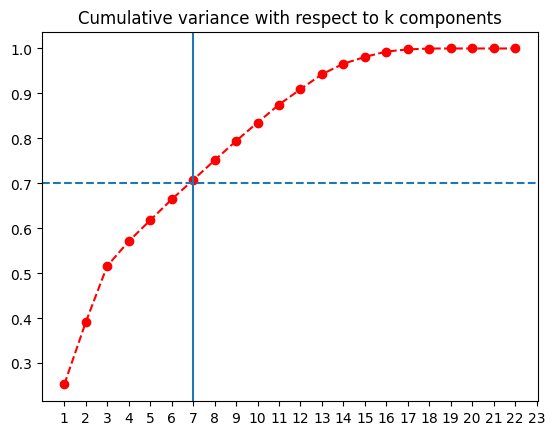

In [133]:
xs = list(cumulative_variance.keys())
ys = list(cumulative_variance.values())

plt.plot(xs,ys,'ro', linestyle='dashed')
plt.axhline(y=0.7, linestyle = 'dashed')
plt.axvline(x = 7)
plt.xticks([i for i in range(1,24)])
plt.title('Cumulative variance with respect to k components')

In [154]:
newPCA = PCA(dimension=7).decomposition(new)
projected = newPCA.projection(new)

In [156]:
projected_data = pd.DataFrame(projected)

In [161]:
projected_data

,0,1,2,3,4,5,6
0,0.369013,-2.160284,-0.396444,0.759492,2.942567,0.357512,-0.194744
1,0.080190,0.447543,-0.924502,0.126733,-0.955291,-0.568717,-0.640784
2,-1.470811,-2.227947,-3.248590,-0.031737,-1.770162,-0.540259,-1.218541
3,0.624201,0.451522,0.184744,0.227863,-0.048653,0.590936,0.287719
4,0.206114,0.423709,0.104382,0.027240,0.001221,-0.773578,0.525623
...,...,...,...,...,...,...,...
839076,-0.116621,0.402400,0.638994,-0.132437,0.117945,1.109873,0.931946
839077,-0.282546,0.422177,1.404765,0.131523,-0.365208,0.254408,-0.110340
839078,0.399745,0.443395,0.265595,0.108236,-0.049302,0.962295,0.695358
839079,0.240675,0.436996,0.744229,0.069321,-0.130518,-0.492380,-0.907483


In [159]:
customer_view['CustomerID']

0         C1010011
1         C1010012
2         C1010014
3         C1010018
4         C1010024
            ...   
839076    C9099836
839077    C9099877
839078    C9099919
839079    C9099941
839080    C9099956
Name: CustomerID, Length: 839081, dtype: object

In [163]:
projected_data.index = customer_view['CustomerID']

In [164]:
projected_data

,0,1,2,3,4,5,6
CustomerID,,,,,,,
C1010011,0.369013,-2.160284,-0.396444,0.759492,2.942567,0.357512,-0.194744
C1010012,0.080190,0.447543,-0.924502,0.126733,-0.955291,-0.568717,-0.640784
C1010014,-1.470811,-2.227947,-3.248590,-0.031737,-1.770162,-0.540259,-1.218541
C1010018,0.624201,0.451522,0.184744,0.227863,-0.048653,0.590936,0.287719
C1010024,0.206114,0.423709,0.104382,0.027240,0.001221,-0.773578,0.525623
...,...,...,...,...,...,...,...
C9099836,-0.116621,0.402400,0.638994,-0.132437,0.117945,1.109873,0.931946
C9099877,-0.282546,0.422177,1.404765,0.131523,-0.365208,0.254408,-0.110340
C9099919,0.399745,0.443395,0.265595,0.108236,-0.049302,0.962295,0.695358


Saving our projected data.

In [167]:
projected_data.to_csv('projected_data.csv')

This little scripts makes it always ready to be used and with the right format. 

In [13]:
loaded_data = pd.read_csv('projected_data.csv')
loaded_data.index = loaded_data.CustomerID
loaded_data = loaded_data.drop(columns=['CustomerID'])

In [3]:
loaded_data

,0,1,2,3,4,5,6
CustomerID,,,,,,,
C1010011,0.369013,-2.160284,-0.396444,0.759492,2.942567,0.357512,-0.194744
C1010012,0.080190,0.447543,-0.924502,0.126733,-0.955291,-0.568717,-0.640784
C1010014,-1.470811,-2.227947,-3.248590,-0.031737,-1.770162,-0.540259,-1.218541
C1010018,0.624201,0.451522,0.184744,0.227863,-0.048653,0.590936,0.287719
C1010024,0.206114,0.423709,0.104382,0.027240,0.001221,-0.773578,0.525623
...,...,...,...,...,...,...,...
C9099836,-0.116621,0.402400,0.638994,-0.132437,0.117945,1.109873,0.931946
C9099877,-0.282546,0.422177,1.404765,0.131523,-0.365208,0.254408,-0.110340
C9099919,0.399745,0.443395,0.265595,0.108236,-0.049302,0.962295,0.695358


# 2.3 Cluster!

We need to setup a PySpark environment to perform a MapReduce pipeline. 

In [2]:
import findspark
findspark.init()
import pyspark

import logging
s_logger = logging.getLogger('py4j.java_gateway')
s_logger.setLevel(logging.ERROR)
sc = pyspark.SparkContext(appName='Cluster')  

We are loading the file we made from the PCA procedure over the engineered customer view.

In [36]:
data = sc.textFile('projected_data.csv')

Then we are doing a little bit of preprocessing: we are removing the first line because it contains the name of the columns with $filter$ function, and then we are defining a subroutine to actually have the data in a useful format. 

In [37]:
header = data.first()
data = data.filter(lambda row: row != header)

In [38]:
def formatting(row):
    splitted = row.split(',')
    stripped = list(map(lambda spl: spl.strip(), splitted))
    return (stripped[0], np.array(list(map(float, stripped[1:]))))

data = data.map(lambda row: formatting(row))

This is just to ensure that we have made a correct formatting: we want the $CustomerID$ as a key, to which we associate a $numpy.ndarray$ that contains numeric values for the feature we defined through the PCA.

In [35]:
data.first()

('C1010011',
 array([ 0.36901321, -2.1602838 , -0.3964439 ,  0.75949164,  2.9425666 ,
         0.35751245, -0.19474423]))

Now we are defining a class for the actual cluster. The methods are here described:
- $init$ is just the class-builder: the parameters of this class are $dim$ the dimension of the data-samples, the number of cluster $k$, the tolerance $\epsilon$ to declare convergence, the number of $max_run$ and a $seed$ for results reproduction;
- $euclidean\ distance$ is a method that leverages $linalg$ module of Numpy to define the euclidean distance as the norm of a difference; 
- $k\ means\ initialization$ initializes randomly $k$ centroids whose dimension is $dim$;
- $find\ centroid$ assigns to each data point its cluster through computing its closest centroid;
- $loss\ function$ is the cost of the procedure, defined as $\sum_{j=1}^{k} || \mu^t_j - \mu^{t-1}_j ||^2$, where $\mu$ is the centroids-vector;
- $fit$ finds the best cluster for given data: it uses a MapReduce pipeline to find and update the best centroid for the given data;
- $predict$ assign to each data point its cluster after the $fit$ operation: also this is a MapReduce pipeline;
- $dispersion$ is a method that we are going to use to define the elbow method;
- $silhouette$ is another metric for optimization with respect to parameter $k$. 

In [39]:
class Cluster:
    def __init__(self, dim, k=2, epsilon=0.001, max_run=10, seed=None):
        self.k = k
        self.dim = dim
        self.epsilon = epsilon
        self.max_run = max_run
        self.seed = seed

    def euclidean_distance(self, a,b):
        a = np.array(a)
        b = np.array(b)
        return np.linalg.norm(a-b)

    def k_means_initialization(self, seed):
        np.random.seed(seed)
        return np.random.rand(self.k, self.dim)

    def find_centroid(self, x: np.ndarray, centroids: np.ndarray):
        distances = np.array([self.euclidean_distance(x, centroid) for centroid in centroids])
        return np.argmin(distances)
    
    def loss_function(self, centroids_t, centroids_t_1):
        return sum([np.power(self.euclidean_distance(centroids_t[i], centroids_t_1[i]), 2) 
                   for i in range(len(centroids_t))])
    
    def fit(self, data):
        centros = self.k_means_initialization(self.seed)
        prev_centros = np.zeros((self.k, self.dim))
        counter = 0
        loss_record = [self.loss_function(centros, prev_centros)]
        while self.loss_function(centros, prev_centros) > self.epsilon and counter < self.max_run:
            temp = data.map(lambda tup: (tup[1], self.find_centroid(tup[1], centros)))\
                       .map(lambda tup: (tup[1], np.array(tup[0])))\
                       .aggregateByKey((0,0), lambda a,b: (a[0] + b, a[1] + 1),
                                                   lambda a,b: (a[0] + b[0], a[1] + b[1]))\
                       .map(lambda tup: tup[1][0]/tup[1][1])\
                       .collect()
            prev_centros = centros
            centros = temp
            loss_record.append(self.loss_function(centros, prev_centros))
            counter += 1
        return centros, loss_record

    def predict(self, data):
        centros, _ = self.fit(data)
        cluster = data.map(lambda tup: (tup[0], self.find_centroid(tup[1], centros)))\
                      .collect()
        partition = {}
        for index in range(len(centros)):
            partition[index] = []
        for tuple in cluster: 
            partition[tuple[1]].append(tuple[0])
        return partition, centros
    
    def distortion(self, data):
        partition, centros = self.predict(data)
        distortion = 0
        data = data.collect()
        data_dic = {}
        for point in data:
            data_dic[point[0]] = point[1]
        for key in partition.keys():
            for clus in partition[key]:
                distortion += np.power(self.euclidean_distance(data_dic[clus], centros[key]),2)
        return distortion

    def silhouette(self, data):
        partition, centros = self.predict(data)
        data = data.collect()
        data_dic = {}
        a = {}
        b = {}
        for point in data:
            data_dic[point[0]] = point[1]
        for key in partition.keys():
            for clus in partition[key]:
                a[clus] = (1/(len(partition[key])-1))*sum([self.euclidean_distance(data_dic[clus], data_dic[other])
                                                            for other in partition[key]
                                                            if other != clus])
                b[clus] = min([(1/len(partition[centr]))*sum([self.euclidean_distance(data_dic[clus], data_dic[other]) for other in partition[centr]])
                                for centr in partition.keys()
                                if centr != key])
        s = {}
        for point in a.keys():
            s[point] = (b[point]-a[point])/(max(a[point], b[point]))
        silhouette = {}
        for key in partition.keys():
            silhouette[key] = sorted([s[point] for point in s.keys() if point in partition[key]])
        return silhouette

### *Optimal number of clusters: elbow and silhouette*

We now want to plot the dispersion of the clustering procedure with respect to a range of k. We are running our algorithm for values of $k$ from 1 to 15 for a max of 5 iterations, in order to find the elbow, the point in the k-distorsion graphic where we find the optimal value because going forward can bring overfitting risk.  

Distorsion is just defined as the cumulative squared sum of each point from its assigned centroid. 

##### *Elbow method*

In [9]:
distortions = {}
semilla = 121233
for i in range(1,16):
    model = Cluster(dim=7, k=i, epsilon=0.1, max_run=5, seed = semilla)
    distortions[i] = model.distortion(data)

In [13]:
distortions

{1: 6916673.929202064,
 2: 6510742.853141149,
 3: 5982868.972166702,
 4: 5363332.86779994,
 5: 5070135.208490485,
 6: 4810897.213285187,
 7: 4367032.630776385,
 8: 4027784.27381661,
 9: 3906225.613540421,
 10: 3776149.9358868585,
 11: 3655664.203494894,
 12: 3546839.0530996746,
 13: 3405264.900319946,
 14: 3353986.165296961,
 15: 3297397.79535586}

Text(0.5, 1.0, 'Elbow method: euristhic for optimality in clustering')

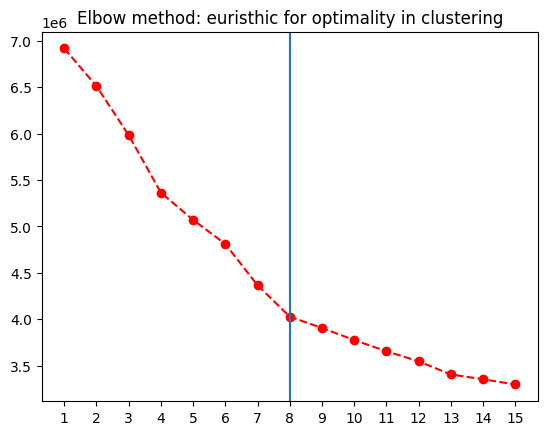

In [15]:
xs = list(distortions.keys())
ys = list(distortions.values())

plt.plot(xs,ys,'ro', linestyle='dashed')
plt.axvline(x = 8)
plt.xticks(xs)
plt.title('Elbow method: euristhic for optimality in clustering')

As we can see the behaviour of the euristhic is almost regular in the chosen range for k. With respect to choices we made to tune the parameters, we can consider the idea that making the algorithm running for more iterations would have provided us a better shaped curve. In the case we are now considering, the most likely elbow point is the one corresponding to $k=8$.

##### *Silhouette method*

We can use silhouette to evaluate different likley results.

In [ ]:
silhouette_scores = {}
semilla = 121233
for i in range(1,15):
    model = Cluster(dim=7, k=i, epsilon=0.1, max_run=30, seed = semilla)
    sil = model.silhouette(data)
    silhouette_scores[i] = sum(list(sil.values()))/len(list(sil.values()))